<h1 align="center"><font color='Orange'>ETL & FE Notebook  </font></h1> 

<h2 align="center"><font color='Orange'> The quieter you become the more you are able to hear. </font></h2> 

# 1 Import Packages

In [1]:
# Packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
from collections import Counter
from sklearn.feature_selection import mutual_info_classif
warnings.filterwarnings('ignore')
####################
from sklearn import *
import xgboost as xgb


# 2. Data: Train an test  

In [2]:
# Train data 
train = pd.read_csv("../input/train.csv")
train.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


In [3]:
# test data 
test = pd.read_csv("../input/test.csv")
test.head()

,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


<h1 align="left"><font color='Orange'> I . ETL  </font></h1> 

# 1. Features Dico

In [4]:
Features=dict()
Features['All']=list(train.columns)
Features['target']=['target']
Features['train']= list(set(train.columns)- set(['id','target']))

# 2. X_train/ X_test datasets

In [5]:
X_train=train[Features['train']]
X_test=test[Features['train']]

In [6]:
X_train.shape

(595212, 57)

In [7]:
X_test.shape

(892816, 57)

In [8]:
Y=train.target

# 3. Benchmark for FE 

In [9]:
import random
random.seed( 3 )

def gini(y, pred):
    fpr, tpr, thr = metrics.roc_curve(y, pred, pos_label=1)
    g = 2 * metrics.auc(fpr, tpr) - 1
    return g

def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

x1, x2, y1, y2 = model_selection.train_test_split(X_train, train['target'], test_size=0.3, random_state=6)
watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
params = {'eta': 0.09, 'max_depth': 6, 'objective': 'binary:logistic', 'seed': 16, 'silent': True, 'colsample_bytree': 0.6}
model = xgb.train(params, xgb.DMatrix(x1, y1), 1000,  watchlist, feval=gini_xgb, maximize=True, verbose_eval=50, early_stopping_rounds=100)

[0]	train-error:0.036501	valid-error:0.036245	train-gini:0.22002	valid-gini:0.207044
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[50]	train-error:0.036515	valid-error:0.036256	train-gini:0.336831	valid-gini:0.275488
[100]	train-error:0.036503	valid-error:0.03625	train-gini:0.418744	valid-gini:0.282424
[150]	train-error:0.036491	valid-error:0.03625	train-gini:0.470955	valid-gini:0.278719
Stopping. Best iteration:
[86]	train-error:0.036503	valid-error:0.03625	train-gini:0.400169	valid-gini:0.283463



With this XGb and with those Features we have a **valid Gini : 0.285829** : this is our Benchmark for Feature Engineering

> <h1 align="left"><font color='Orange'> II . FE </font></h1> 

# 1. Level 1 of FE 

In [10]:
train_float = X_train.select_dtypes(include=['float64'])
train_int = X_train.select_dtypes(include=['int64'])

In [11]:
train_float.head()

,ps_calc_03,ps_reg_01,ps_reg_03,ps_car_13,ps_car_15,ps_calc_02,ps_car_12,ps_car_14,ps_reg_02,ps_calc_01
0,0.2,0.7,0.718070,0.883679,3.605551,0.5,0.400000,0.370810,0.2,0.6
1,0.3,0.8,0.766078,0.618817,2.449490,0.1,0.316228,0.388716,0.4,0.3
2,0.1,0.0,-1.000000,0.641586,3.316625,0.7,0.316228,0.347275,0.0,0.5
3,0.1,0.9,0.580948,0.542949,2.000000,0.9,0.374166,0.294958,0.2,0.6
4,0.0,0.7,0.840759,0.565832,2.000000,0.6,0.316070,0.365103,0.6,0.4


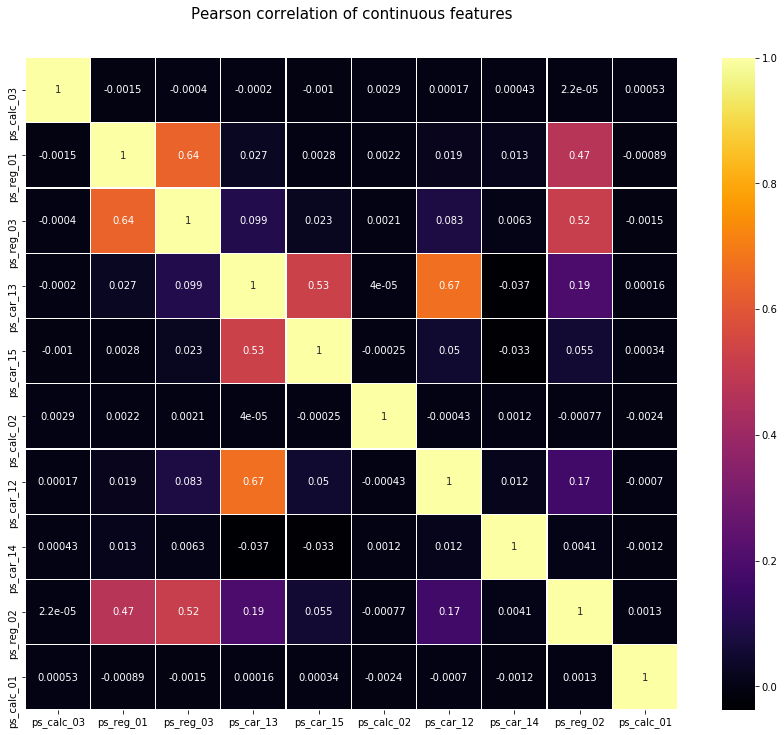

In [12]:
colormap = plt.cm.inferno
plt.figure(figsize=(16,12))
plt.title('Pearson correlation of continuous features', y=1.05, size=15)
sns.heatmap(train_float.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True)

In [13]:
Features['Reg']=['ps_reg_03','ps_reg_02','ps_reg_01'] # Reg maybe regression !! Why not ? 

In [14]:
X_train.ps_reg_03.describe()

count    595212.000000
mean          0.551102
std           0.793506
min          -1.000000
25%           0.525000
50%           0.720677
75%           1.000000
max           4.037945
Name: ps_reg_03, dtype: float64

In [15]:
X_train.ps_reg_02.describe()

count    595212.000000
mean          0.439184
std           0.404264
min           0.000000
25%           0.200000
50%           0.300000
75%           0.600000
max           1.800000
Name: ps_reg_02, dtype: float64

In [16]:
X_train.ps_reg_01.describe()

count    595212.000000
mean          0.610991
std           0.287643
min           0.000000
25%           0.400000
50%           0.700000
75%           0.900000
max           0.900000
Name: ps_reg_01, dtype: float64

In [17]:
Features['FE']=['sum_Reg']

In [18]:
X_train['Sum_Reg']=X_train['ps_reg_03']+X_train['ps_reg_02']+X_train['ps_reg_01']

Now We will chek if the FE_i increase the Gini metric

In [19]:
import random
random.seed( 3 )
x1, x2, y1, y2 = model_selection.train_test_split(X_train, train['target'], test_size=0.3, random_state=6)
watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
params = {'eta': 0.09, 'max_depth': 6, 'objective': 'binary:logistic', 'seed': 16, 'silent': True, 'colsample_bytree': 0.6}
model = xgb.train(params, xgb.DMatrix(x1, y1), 1000,  watchlist, feval=gini_xgb, maximize=True, verbose_eval=50, early_stopping_rounds=100)

[0]	train-error:0.036501	valid-error:0.036245	train-gini:0.22002	valid-gini:0.207044
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[50]	train-error:0.036508	valid-error:0.03625	train-gini:0.337658	valid-gini:0.277899
[100]	train-error:0.036491	valid-error:0.036239	train-gini:0.417851	valid-gini:0.285824
[150]	train-error:0.036477	valid-error:0.036239	train-gini:0.471024	valid-gini:0.284577
[200]	train-error:0.036443	valid-error:0.03625	train-gini:0.510376	valid-gini:0.282194
Stopping. Best iteration:
[125]	train-error:0.036489	valid-error:0.036239	train-gini:0.447285	valid-gini:0.286908



So like you see with only 5 Features we passed from **valid Gini : 0.2858**  to **valid Gini :0.2860**  

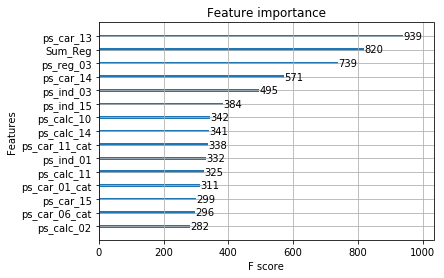

In [20]:
xgb.plot_importance(booster=model,max_num_features=15)

In [21]:
for a in [0,1,5,10,20,100]:
    FE_1='logps_car13_'+str(a)
    print(FE_1)
    X_train[FE_1]=np.log(a+X_train.ps_car_13)

logps_car13_0
logps_car13_1
logps_car13_5
logps_car13_10
logps_car13_20
logps_car13_100


In [22]:
import random
random.seed( 3 )
x1, x2, y1, y2 = model_selection.train_test_split(X_train, train['target'], test_size=0.3, random_state=6)
watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
params = {'eta': 0.09, 'max_depth': 6, 'objective': 'binary:logistic', 'seed': 16, 'silent': True, 'colsample_bytree': 0.6}
model = xgb.train(params, xgb.DMatrix(x1, y1), 1000,  watchlist, feval=gini_xgb, maximize=True, verbose_eval=50, early_stopping_rounds=100)

[0]	train-error:0.036508	valid-error:0.036267	train-gini:0.219759	valid-gini:0.206665
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[50]	train-error:0.036508	valid-error:0.036234	train-gini:0.33466	valid-gini:0.277356
[100]	train-error:0.036494	valid-error:0.036228	train-gini:0.417167	valid-gini:0.285942
[150]	train-error:0.036474	valid-error:0.036222	train-gini:0.471128	valid-gini:0.284096
Stopping. Best iteration:
[90]	train-error:0.036494	valid-error:0.036228	train-gini:0.399931	valid-gini:0.286139



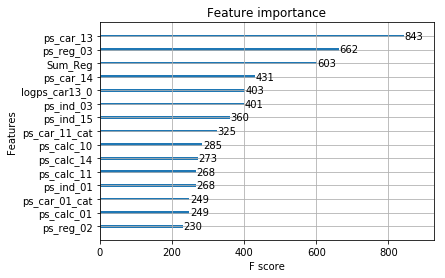

In [23]:
xgb.plot_importance(booster=model,max_num_features=15)

In [24]:
X_train.ps_reg_03.value_counts()

-1.000000    107772
 0.633936       664
 0.602599       637
 0.704894       627
 0.587899       616
 0.680074       598
 0.596343       597
 0.621993       592
 0.668487       582
 0.664737       581
 0.631467       565
 0.575543       563
 0.602080       561
 0.657172       561
 0.619476       557
 0.573367       555
 0.684197       555
 0.701338       553
 0.517204       552
 0.647592       551
 0.669888       550
 0.616948       544
 0.557898       539
 0.667083       539
 0.653357       536
 0.740355       535
 0.648074       535
 0.647109       531
 0.615934       530
 0.630971       530
              ...  
 1.676492         1
 1.612645         1
 0.230489         1
 1.877998         1
 1.490386         1
 1.686527         1
 1.581139         1
 1.489127         1
 1.326885         1
 0.278388         1
 1.417965         1
 2.486715         1
 1.947434         1
 1.650757         1
 1.518017         1
 2.198437         1
 1.630759         1
 1.748571         1
 1.544547         1


In [25]:
X_train.ps_car_13.value_counts()

0.674583    386
0.741689    377
0.692776    363
0.841781    362
0.749228    353
0.659561    350
0.747765    333
0.596391    326
0.743720    317
0.687777    312
0.679694    308
0.901055    300
0.709222    297
0.763947    295
0.676754    289
0.751101    282
0.690685    277
0.701401    273
0.685927    272
0.682030    271
0.752613    270
0.607205    269
0.673280    267
0.690924    258
0.679314    257
0.753573    255
0.657443    253
0.674506    252
0.802321    247
0.711723    244
           ... 
0.667660      1
1.058788      1
0.664305      1
1.062273      1
0.938747      1
1.188695      1
0.632833      1
0.861265      1
0.800823      1
0.681692      1
0.980039      1
0.883931      1
1.034320      1
0.648941      1
1.384425      1
0.839778      1
0.864331      1
0.849539      1
0.984699      1
0.858357      1
1.952002      1
0.903859      1
1.337013      1
0.621119      1
1.583854      1
1.113268      1
1.517569      1
0.808997      1
1.175791      1
0.500000      1
Name: ps_car_13, Length:

In [26]:
X_train['Sum_Top_2']=X_train.ps_car_13+X_train.ps_reg_03
X_train['Prod_Top_2']=X_train.ps_car_13*X_train.ps_reg_03
X_train['M_Top_2']=X_train.ps_car_13-X_train.ps_reg_03
X_train['ratio_Top_2']=X_train.ps_car_13 / X_train.ps_reg_03

In [27]:
import random
random.seed( 3 )
x1, x2, y1, y2 = model_selection.train_test_split(X_train, train['target'], test_size=0.3, random_state=6)
watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
params = {'eta': 0.09, 'max_depth': 6, 'objective': 'binary:logistic', 'seed': 16, 'silent': True, 'colsample_bytree': 0.6}
model = xgb.train(params, xgb.DMatrix(x1, y1), 1000,  watchlist, feval=gini_xgb, maximize=True, verbose_eval=50, early_stopping_rounds=100)

[0]	train-error:0.036494	valid-error:0.036323	train-gini:0.213177	valid-gini:0.205722
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[50]	train-error:0.036498	valid-error:0.03625	train-gini:0.334688	valid-gini:0.275656
[100]	train-error:0.036482	valid-error:0.036239	train-gini:0.42144	valid-gini:0.286605
[150]	train-error:0.036458	valid-error:0.036245	train-gini:0.476522	valid-gini:0.283677
[200]	train-error:0.036422	valid-error:0.03625	train-gini:0.5112	valid-gini:0.281337
Stopping. Best iteration:
[112]	train-error:0.036482	valid-error:0.036245	train-gini:0.436794	valid-gini:0.286899



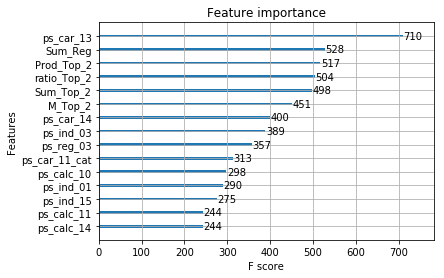

In [28]:
xgb.plot_importance(booster=model,max_num_features=15)

<h1 align="Center"><font color='Orange'>  Stay tuned  ! </font></h1> 